In [ ]:
import numpy as np
import pandas as pd
from nixtla import NixtlaClient
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score # Mengimpor metrik untuk evaluasi model regresi (MSE, MAPE, dan R²)


In [ ]:
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame
from autogluon.timeseries.models import WaveNetModel
import pandas as pd


In [ ]:
from google.colab import files
uploaded = files.upload()
import pandas as pd

Y_df = pd.read_excel('AMD.xlsx')
Y_df = Y_df.reset_index(drop=True)
Y_df.head()


Saving AMD.xlsx to AMD (5).xlsx


,Date,Open,High,Low,Close,Adj Close,Volume
0,2025-04-25,93.28,97.10,92.85,96.65,96.65,28529100
1,2025-04-24,91.59,94.75,90.37,94.47,94.47,33681900
2,2025-04-23,91.88,93.74,90.12,90.39,90.39,41102600
3,2025-04-22,86.12,87.17,85.17,86.26,86.26,35236700
4,2025-04-21,86.02,86.14,83.75,85.56,85.56,33855400


In [ ]:
Y_df['Date'] = pd.to_datetime(Y_df['Date'])  # Mengubah kolom 'Date' menjadi format datetime agar bisa digunakan dalam analisis time series
Y_df.rename(columns={"Date":"timestamp","unique_id" :"item_id", # Merename kolom 'Date' menjadi 'timestamp', 'unique_id' menjadi 'item_id', dan 'y' menjadi 'target'
"y": "target"},inplace = True)
Y_df['item_id'] = 'AMD'  # Menetapkan nilai 'AMD' untuk seluruh kolom 'item_id', mengindikasikan ID untuk entitas (misal perusahaan maskapai)
data = TimeSeriesDataFrame.from_data_frame(
 Y_df,
 id_column="item_id",
 timestamp_column="timestamp"
) # Mengkonversi DataFrame ke format TimeSeriesDataFrame dengan kolom 'item_id' dan 'timestamp' sebagai kolom utama
data.tail() # Menampilkan 5 baris terakhir dari DataFrame 'data' untuk melihat hasil akhir

Open  High   Low  Close  Adj Close  Volume
item_id timestamp                                            
AMD     1980-03-21    0  3.02  2.91   2.92       2.92  130800
        1980-03-20    0  3.06  3.01   3.01       3.01  159600
        1980-03-19    0  3.08  3.02   3.04       3.04  295200
        1980-03-18    0  3.13  2.94   3.03       3.03  727200
        1980-03-17    0  3.30  3.13   3.15       3.15  219600

In [ ]:
train_data = data.head(132)
test_data = data.tail(12)

In [ ]:
predictor = TimeSeriesPredictor( # Membuat instance TimeSeriesPredictor untuk melakukan prediksi pada data time series
    prediction_length=prediction_length, # Menentukan panjang prediksi, yaitu jumlah waktu yang ingin diprediksi ke depan
    target='Close',  # Menentukan kolom target untuk prediksi, dalam hal ini kolom 'Close' yang mungkin merujuk pada harga penutupan saham
    freq='y'  # Menetapkan frekuensi data time series, 'y' berarti data tahunan, bisa diubah ke 'D' (harian), 'M' (bulanan), dsb
).fit(train_data, presets="chronos_tiny") # Melatih model pada data pelatihan menggunakan preset 'chronos_tiny'


/usr/local/lib/python3.11/dist-packages/autogluon/timeseries/predictor.py:198: FutureWarning: 'y' is deprecated and will be removed in a future version, please use 'YE' instead.
  offset = pd.tseries.frequencies.to_offset(self.freq)
Frequency 'y' stored as 'YE-DEC'
Beginning AutoGluon training...
AutoGluon will save models to '/content/AutogluonModels/ag-20250504_150803'
=================== System Info ===================
AutoGluon Version:  1.3.0
Python Version:     3.11.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Mar 30 16:01:29 UTC 2025
CPU Count:          2
GPU Count:          0
Memory Avail:       10.27 GB / 12.67 GB (81.0%)
Disk Space Avail:   65.51 GB / 107.72 GB (60.8%)
Setting presets to: chronos_tiny

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'YE-DEC',
 'hyperparameters': {'Chronos': {'model_path': 'tiny'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length

In [ ]:
predictions = predictor.predict(train_data)  # Menggunakan model predictor untuk membuat prediksi berdasarkan data pelatihan (train_data)
predictions.head() # Menampilkan 5 baris pertama dari hasil prediksi untuk melihat output prediksi

data with frequency 'IRREG' has been resampled to frequency 'YE-DEC'.
Model not specified in predict, will default to the model with the best validation score: Chronos[tiny]


mean        0.1        0.2         0.3         0.4  \
item_id timestamp                                                              
AMD     2026-12-31  105.776474  92.909927  95.347801   97.875969  100.945877   
        2027-12-31  110.200760  93.632263  96.431305  101.758499  105.279869   
        2028-12-31  112.458046  95.618675  97.153633  101.577919  107.988609   
        2029-12-31  106.995407  89.388565  95.708969   95.708969   99.501213   
        2030-12-31  104.873558  86.499237  89.027397   91.555557   98.959457   

                           0.5         0.6         0.7         0.8         0.9  
item_id timestamp                                                               
AMD     2026-12-31  106.092484  107.808029  109.252686  115.753677  123.789619  
        2027-12-31  109.252693  111.419693  115.302223  123.879906  127.762444  
        2028-12-31  111.058517  114.850761  120.268250  131.825562  136.701294  
        2029-12-31  106.543945  113.767265  114.850761  118.281837  126.949829  
        2030-12-31  105.189575  108.530365  119.455627  122.074081  123.157578

In [ ]:
def calculate_error_metrics(actual, predicted): # Mendefinisikan fungsi untuk menghitung metrik kesalahan antara nilai aktual dan prediksi
    mse = mean_squared_error(actual, predicted)  # Menghitung Mean Squared Error (MSE) antara nilai aktual dan prediksi
    rmse = np.sqrt(mse) # Menghitung Root Mean Squared Error (RMSE) dengan mengambil akar kuadrat dari MSE
    mape = mean_absolute_percentage_error(actual, predicted) # Menghitung Mean Absolute Percentage Error (MAPE)
    r2 = r2_score(actual, predicted) # Menghitung R-squared (koefisien determinasi) yang menunjukkan seberapa baik prediksi sesuai dengan data aktual
    n = len(actual)  #Menghitung jumlah data aktual (n)
    p = 1  # jumlah prediktor; sesuaikan jika lebih dari satu
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)  # Menghitung adjusted R-squared untuk mengoreksi nilai R-squared dengan mempertimbangkan jumlah prediktor

    print(f"MSE         : {mse}")
    print(f"RMSE        : {rmse}")
    print(f"MAPE        : {mape}")
    print(f"r2          : {r2}")
    print(f"adjusted_r2 : {adjusted_r2}")

In [ ]:
calculate_error_metrics(test_data['Close'], predictions['mean']['AMD'])

MSE         : 10557.651222358092
RMSE        : 102.75043173806178
MAPE        : 37.65512770941324
r2          : -166110.44477558276
adjusted_r2 : -182721.58925314102


data with frequency 'IRREG' has been resampled to frequency 'YE-DEC'.


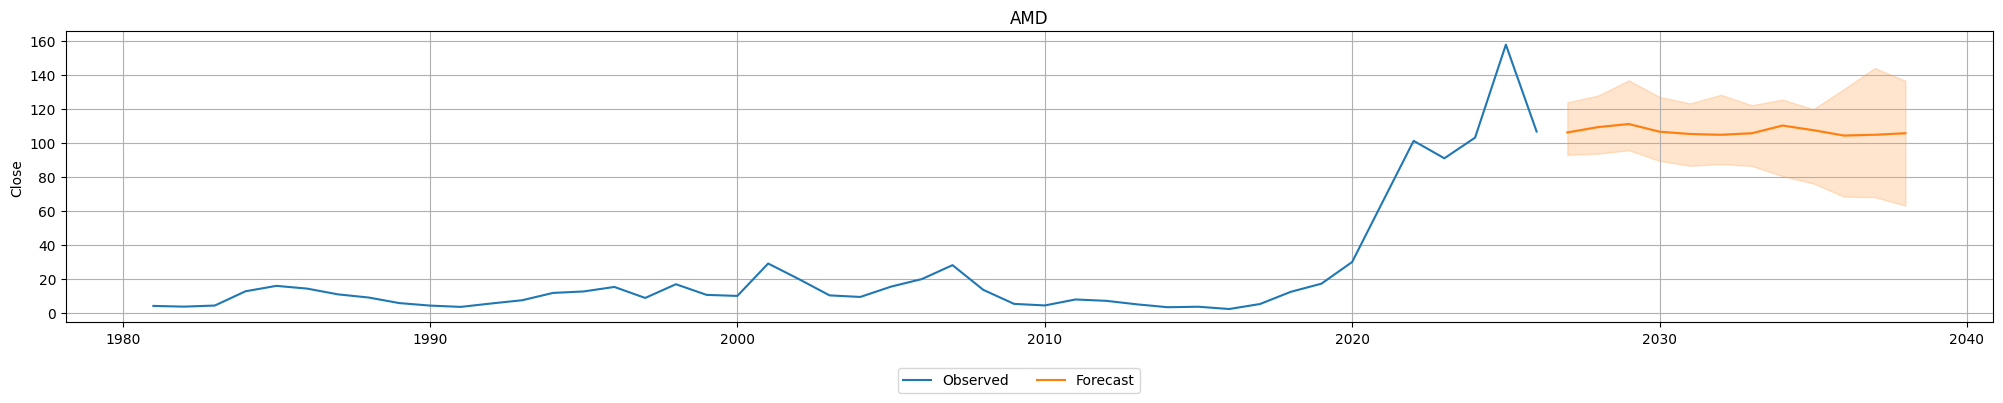

In [ ]:
predictor.plot( # Memanggil fungsi plot dari objek predictor untuk memvisualisasikan hasil prediksi
 data=Y_df, # Data asli yang digunakan sebagai acuan visualisasi (berisi data historis)
 predictions=predictions, # Data hasil prediksi yang akan ditampilkan pada grafik
 item_ids=["AMD"], # Menentukan ID item yang ingin divisualisasikan (dalam hal ini hanya 'AMD')
 max_history_length=200, # Menentukan panjang maksimum data historis yang akan ditampilkan dalam plot
);